### LOADING PREPROCESSED DATA

Loading GloVe word embeddings. Building functions to convert words into their vector representations and vice versa. Loading babi induction task 10K dataset.

In [1]:
import numpy as np
from __future__ import division

filename = 'glove.6B.100d.txt'

def loadEmbeddings(filename):
    vocab = []
    embd = []
    file = open(filename,'r')
    for line in file.readlines():
        row = line.strip().split(' ')
        vocab.append(row[0])
        embd.append(row[1:])
    print('Loaded!')
    file.close()
    return vocab,embd
vocab,embd = loadEmbeddings(filename)


word_vec_dim = len(embd[0])

vocab.append('<UNK>')
embd.append(np.asarray(embd[vocab.index('unk')],np.float32)+0.01)

vocab.append('<EOS>')
embd.append(np.asarray(embd[vocab.index('eos')],np.float32)+0.01)

vocab.append('<PAD>')
embd.append(np.zeros((word_vec_dim),np.float32))

embedding = np.asarray(embd)
embedding = embedding.astype(np.float32)

def word2vec(word):  # converts a given word into its vector representation
    if word in vocab:
        return embedding[vocab.index(word)]
    else:
        return embedding[vocab.index('<UNK>')]

def most_similar_eucli(x):
    xminusy = np.subtract(embedding,x)
    sq_xminusy = np.square(xminusy)
    sum_sq_xminusy = np.sum(sq_xminusy,1)
    eucli_dists = np.sqrt(sum_sq_xminusy)
    return np.argsort(eucli_dists)

def vec2word(vec):   # converts a given vector representation into the represented word 
    most_similars = most_similar_eucli(np.asarray(vec,np.float32))
    return vocab[most_similars[0]]

import pickle

with open ('embeddingPICKLE', 'rb') as fp:
    processed_data = pickle.load(fp)

fact_stories = processed_data[0]
questions = processed_data[1]
answers = np.reshape(processed_data[2],(len(processed_data[2])))
test_fact_stories = processed_data[3]
test_questions = processed_data[4]
test_answers = np.reshape(processed_data[5],(len(processed_data[5])))

print fact_stories.shape
print questions.shape
print answers.shape
print test_fact_stories.shape
print test_questions.shape
print test_answers.shape
    

Loaded!
(10000, 9, 6, 100)
(10000, 5, 100)
(10000,)
(1000, 9, 6, 100)
(1000, 5, 100)
(1000,)


### CREATING TRAINING AND VALIDATION DATA

In [2]:
from __future__ import division

train_fact_stories = []
train_questions = []
train_answers = []
val_fact_stories = []
val_questions = []
val_answers = []

p=90 #(90% data used for training. Rest for validation)
    
train_len = int((p/100)*len(fact_stories))
val_len = int(((100-p)/100)*len(fact_stories))

train_fact_stories = fact_stories[0:train_len] 
val_fact_stories = fact_stories[train_len:(train_len+val_len)]

train_questions = questions[0:train_len] 
val_questions = questions[train_len:(train_len+val_len)] 

train_answers = answers[0:train_len] 
val_answers = answers[train_len:(train_len+val_len)] 


### SENTENCE READING LAYER IMPLEMENTED BEFOREHAND 

Positionally encode the word vectors in each sentence, and combine all the words in the sentence to create a fixed sized vector representation for the sentence.

"sentence embedding"

In [3]:
def sentence_reader(fact_stories): #positional_encoder
    
    pe_fact_stories = np.zeros((fact_stories.shape[0],fact_stories.shape[1],word_vec_dim),np.float32)
    
    for fact_story_index in xrange(0,len(fact_stories)):
        for fact_index in xrange(0,len(fact_stories[fact_story_index])):
            
            M = len(fact_stories[fact_story_index,fact_index]) #length of sentence (fact)
            l = np.zeros((word_vec_dim),np.float32) 
            
            # ljd = (1 − j/M) − (d/D)(1 − 2j/M),
            
            for word_position in xrange(0,M):
                for dimension in xrange(word_vec_dim):
                    
                    j = word_position + 1 # making position start from 1 instead of 0
                    d = dimension + 1 #making dimensions start from 1 isntead of 0 (1-50 instead of 0-49)
                    
                    l[dimension] = (1-(j/M)) - (d/word_vec_dim)*(1-2*(j/M))
                
                fact_stories[fact_story_index,fact_index,word_position] = np.multiply(l,fact_stories[fact_story_index,fact_index,word_position])

            pe_fact_stories[fact_story_index,fact_index] = np.sum(fact_stories[fact_story_index,fact_index],0)

    return pe_fact_stories

train_fact_stories = sentence_reader(train_fact_stories)
val_fact_stories = sentence_reader(val_fact_stories)
test_fact_stories = sentence_reader(test_fact_stories)
                
        

In [4]:
print train_fact_stories.shape
print val_fact_stories.shape
print test_fact_stories.shape

(9000, 9, 100)
(1000, 9, 100)
(1000, 9, 100)


### Function to create randomized batches

In [5]:
def create_batches(fact_stories,questions,answers,batch_size):
    
    shuffle = np.arange(len(questions))
    np.random.shuffle(shuffle)
    
    batches_fact_stories = []
    batches_questions = []
    batches_answers = []
    
    i=0
    
    while i+batch_size<=len(questions):
        batch_fact_stories = []
        batch_questions = []
        batch_answers = []
        
        for j in xrange(i,i+batch_size):
            batch_fact_stories.append(fact_stories[shuffle[j]])
            batch_questions.append(questions[shuffle[j]])
            batch_answers.append(answers[shuffle[j]])
            
        batch_fact_stories = np.asarray(batch_fact_stories,np.float32)
        batch_fact_stories = np.transpose(batch_fact_stories,[1,0,2])
        #result = number of facts x batch_size x fact sentence size x word vector size
        
        batch_questions = np.asarray(batch_questions,np.float32)
        batch_questions = np.transpose(batch_questions,[1,0,2])
        #result = question_length x batch_size x fact sentence size x word vector size
        
        batches_fact_stories.append(batch_fact_stories)
        batches_questions.append(batch_questions)
        batches_answers.append(batch_answers)
        
        i+=batch_size
        
    batches_fact_stories = np.asarray(batches_fact_stories,np.float32)
    batches_questions = np.asarray(batches_questions,np.float32)
    batches_answers = np.asarray(batches_answers,np.float32)
    
    return batches_fact_stories,batches_questions,batches_answers
    


### Hyperparameters

In [6]:
import tensorflow as tf

# Tensorflow placeholders

tf_facts = tf.placeholder(tf.float32, [None,None,word_vec_dim])
tf_questions = tf.placeholder(tf.float32, [None,None,word_vec_dim])
tf_answers = tf.placeholder(tf.int32,[None])
keep_prob = tf.placeholder(tf.float32)

#hyperparameters
epochs = 256
learning_rate = 0.001
hidden_size = 100
passes = 3
beta = 0.0001 #l2 regularization scale


### Low level api implementation of GRU

Returns a tensor of all the hidden states

In [7]:
def GRU(inp,hidden,
        wz,uz,bz,
        wr,ur,br,
        w,u,b,
        seq_len):

    hidden_lists = tf.TensorArray(size=seq_len,dtype=tf.float32)
    
    i=0
    
    def cond(i,hidden,hidden_lists):
        return i < seq_len
    
    def body(i,hidden,hidden_lists):
        
        x = inp[i]

        # GRU EQUATIONS:
        z = tf.sigmoid( tf.matmul(x,wz) + tf.matmul(hidden,uz) + bz)
        r = tf.sigmoid( tf.matmul(x,wr) + tf.matmul(hidden,ur) + br)
        h_ = tf.tanh( tf.matmul(x,w) + tf.multiply(r,tf.matmul(hidden,u)) + b)
        hidden = tf.multiply(z,hidden) + tf.multiply((1-z),h_)

        hidden_lists = hidden_lists.write(i,hidden)
        
        return i+1,hidden,hidden_lists
    
    _,_,hidden_lists = tf.while_loop(cond,body,[i,hidden,hidden_lists])
    
    return hidden_lists.stack()
        

### Attention based GRU as used in DMN+ model

Returns only the final hidden state.

In [8]:
def attention_based_GRU(inp,hidden,
                        wr,ur,br,
                        w,u,b,
                        g,seq_len):
    
    i=0
    
    def cond(i,hidden):
        return i < seq_len
    
    def body(i,hidden):
        
        x = inp[i]

        # GRU EQUATIONS:
        r = tf.sigmoid( tf.matmul(x,wr) + tf.matmul(hidden,ur) + br)
        h_ = tf.tanh( tf.matmul(x,w) + tf.multiply(r,tf.matmul(hidden,u)) + b)
        hidden = tf.multiply(g[i],hidden) + tf.multiply((1-g[i]),h_)
        
        return i+1,hidden
    
    _,hidden = tf.while_loop(cond,body,[i,hidden])
    
    return hidden
        

### All the trainable parameters initialized here

In [9]:

# Parameters

# FORWARD GRU PARAMETERS FOR INPUT MODULE

wzf = tf.get_variable("wzf", shape=[word_vec_dim, hidden_size],initializer=tf.contrib.layers.xavier_initializer())
uzf = tf.get_variable("uzf", shape=[hidden_size, hidden_size],initializer=tf.contrib.layers.xavier_initializer())
bzf = tf.Variable(tf.random_uniform(shape=[hidden_size],dtype=tf.float32))

wrf = tf.get_variable("wrf", shape=[word_vec_dim, hidden_size],initializer=tf.contrib.layers.xavier_initializer())
urf = tf.get_variable("urf", shape=[hidden_size, hidden_size],initializer=tf.contrib.layers.xavier_initializer())
brf = tf.Variable(tf.random_uniform(shape=[hidden_size],dtype=tf.float32))

wf = tf.get_variable("wf", shape=[word_vec_dim, hidden_size],initializer=tf.contrib.layers.xavier_initializer())
uf = tf.get_variable("uf", shape=[hidden_size, hidden_size],initializer=tf.contrib.layers.xavier_initializer())
bf = tf.Variable(tf.random_uniform(shape=[hidden_size],dtype=tf.float32))

# BACKWARD GRU PARAMETERS FOR INPUT MODULE

wzb = tf.get_variable("wzb", shape=[word_vec_dim, hidden_size],initializer=tf.contrib.layers.xavier_initializer())
uzb = tf.get_variable("uzb", shape=[hidden_size, hidden_size],initializer=tf.contrib.layers.xavier_initializer())
bzb = tf.Variable(tf.random_uniform(shape=[hidden_size],dtype=tf.float32))

wrb = tf.get_variable("wrb", shape=[word_vec_dim, hidden_size],initializer=tf.contrib.layers.xavier_initializer())
urb = tf.get_variable("urb", shape=[hidden_size, hidden_size],initializer=tf.contrib.layers.xavier_initializer())
brb = tf.Variable(tf.random_uniform(shape=[hidden_size],dtype=tf.float32))

wb = tf.get_variable("wb", shape=[word_vec_dim, hidden_size],initializer=tf.contrib.layers.xavier_initializer())
ub = tf.get_variable("ub", shape=[hidden_size, hidden_size],initializer=tf.contrib.layers.xavier_initializer())
bb = tf.Variable(tf.random_uniform(shape=[hidden_size],dtype=tf.float32))

# GRU PARAMETERS FOR QUESTION MODULE (TO ENCODE THE QUESTIONS)

wzq = tf.get_variable("wzq", shape=[word_vec_dim, hidden_size],initializer=tf.contrib.layers.xavier_initializer())
uzq = tf.get_variable("uzq", shape=[hidden_size, hidden_size],initializer=tf.contrib.layers.xavier_initializer())
bzq = tf.Variable(tf.random_uniform(shape=[hidden_size],dtype=tf.float32))

wrq = tf.get_variable("wrq", shape=[word_vec_dim, hidden_size],initializer=tf.contrib.layers.xavier_initializer())
urq = tf.get_variable("urq", shape=[hidden_size, hidden_size],initializer=tf.contrib.layers.xavier_initializer())
brq = tf.Variable(tf.random_uniform(shape=[hidden_size],dtype=tf.float32))

wq = tf.get_variable("wq", shape=[word_vec_dim, hidden_size],initializer=tf.contrib.layers.xavier_initializer())
uq = tf.get_variable("uq", shape=[hidden_size, hidden_size],initializer=tf.contrib.layers.xavier_initializer())
bq = tf.Variable(tf.random_uniform(shape=[hidden_size],dtype=tf.float32))


# EPISODIC MEMORY

inter_neurons = 1024
w1 = tf.get_variable("w1", shape=[hidden_size*4, inter_neurons],initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.Variable(tf.random_uniform(shape=[inter_neurons],dtype=tf.float32))
w2 = tf.get_variable("w2", shape=[inter_neurons,1],initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.Variable(tf.random_uniform(shape=[1],dtype=tf.float32))

# ATTENTION BASED GRU PARAMETERS

wratt = tf.get_variable("wratt", shape=[hidden_size,hidden_size],initializer=tf.contrib.layers.xavier_initializer())
uratt = tf.get_variable("uratt", shape=[hidden_size,hidden_size],initializer=tf.contrib.layers.xavier_initializer())
bratt = tf.Variable(tf.random_uniform(shape=[hidden_size],dtype=tf.float32))

watt = tf.get_variable("watt", shape=[hidden_size,hidden_size],initializer=tf.contrib.layers.xavier_initializer())
uatt = tf.get_variable("uatt", shape=[hidden_size, hidden_size],initializer=tf.contrib.layers.xavier_initializer())
batt = tf.Variable(tf.random_uniform(shape=[hidden_size],dtype=tf.float32))

# MEMORY UPDATE PARAMETERS

wt = tf.get_variable("wt", shape=[passes,hidden_size*3,hidden_size],initializer=tf.contrib.layers.xavier_initializer())
bt = tf.Variable(tf.random_uniform(shape=[passes,hidden_size],dtype=tf.float32))

# Answer module
    
wa1 = tf.get_variable("wa1", shape=[hidden_size,len(vocab)],initializer=tf.contrib.layers.xavier_initializer())

all_weights = [wzf,uzf,wrf,urf,wf,uf,wzb,uzb,wrb,urb,wb,ub,
               wzq,uzq,wrq,urq,wq,uq,wq,uq,wratt,uratt,watt,uatt,
               w1,w2,wt,wa1]

    

### Dynamic Memory Network + Model Definition

In [10]:
def DMN(tf_facts,tf_questions):
    
    facts_num = tf.shape(tf_facts)[0]
    tf_batch_size = tf.shape(tf_questions)[1]
    question_len = tf.shape(tf_questions)[0]
    
    hidden = tf.zeros([tf_batch_size,hidden_size],tf.float32)

    
    tf_facts = tf.nn.dropout(tf_facts,keep_prob)
    
    # Input Module
    # input fusion layer 
    # bidirectional GRU
    
    forward = GRU(tf_facts,hidden,
                  wzf,uzf,bzf,
                  wrf,urf,brf,
                  wf,uf,bf,
                  facts_num)
    
    backward = GRU(tf.reverse(tf_facts,[0]),hidden,
                   wzf,uzf,bzf,
                   wrf,urf,brf,
                   wf,uf,bf,
                   facts_num)
    
    encoded_input = forward + backward

    # Question Module
    
    question_representation = GRU(tf_questions,hidden,
                                  wzq,uzq,bzq,
                                  wrq,urq,brq,
                                  wq,uq,bq,
                                  question_len)
    
    question_representation = question_representation[question_len-1]

    question_representation = tf.reshape(question_representation,[tf_batch_size,1,hidden_size])
    
    
    # Episodci Memory Module
    
    episodic_memory = question_representation
    
    encoded_input = tf.transpose(encoded_input,[1,0,2])
    #now shape = batch_size x facts_num x hidden_size
    
    
    i=0

    def cond(i,episodic_memory):
        return i < passes
    
    def body(i,episodic_memory):
        
        # Attention Mechanism
        
        Z1 = tf.multiply(encoded_input,question_representation)
        Z2 = tf.multiply(encoded_input,episodic_memory)
        Z3 = tf.abs(tf.subtract(encoded_input,question_representation))
        Z4 = tf.abs(tf.subtract(encoded_input,episodic_memory))
        
        Z = tf.concat([Z1,Z2,Z3,Z4],2)
        
        Z = tf.reshape(Z,[-1,4*hidden_size])
        Z = tf.add( tf.matmul( tf.tanh( tf.add( tf.matmul(Z,w1),b1 ) ),w2 ) , b2)
        Z = tf.reshape(Z,[tf_batch_size,facts_num])
        
        g = tf.nn.softmax(Z)
        g = tf.reshape(g,[tf_batch_size,facts_num])
        g = tf.transpose(g,[1,0])
        g = tf.reshape(g,[facts_num,tf_batch_size,1])
        
        context_vector = attention_based_GRU(tf.transpose(encoded_input,[1,0,2]),
                                             tf.reshape(episodic_memory,[tf_batch_size,hidden_size]),
                                             wratt,uratt,bratt,
                                             watt,uatt,batt,
                                             g,facts_num)
        
        context_vector = tf.reshape(context_vector,[tf_batch_size,1,hidden_size])
        
        # Episodic Memory Update
        
        concated = tf.concat([episodic_memory,context_vector,question_representation],2)
        concated = tf.reshape(concated,[-1,3*hidden_size])
        
        episodic_memory = tf.nn.relu(tf.matmul(concated,wt[i]) + bt[i])
        
        episodic_memory = tf.reshape(episodic_memory,[tf_batch_size,1,hidden_size])

        return i+1,episodic_memory
    
    
    _,episodic_memory = tf.while_loop(cond,body,[i,episodic_memory]) 
    
    # Answer module
    
    episodic_memory = tf.reshape(episodic_memory,[tf_batch_size,hidden_size])

    episodic_memory = tf.nn.dropout(episodic_memory,keep_prob)
    
    y = tf.matmul(episodic_memory,wa1) 
    
    return y

### Cost function, Evaluation, Optimization function 

In [11]:
model_output = DMN(tf_facts,tf_questions)


# l2 regularization
regularizer = 0
for weight in all_weights:
    regularizer += tf.nn.l2_loss(weight)


# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=tf_answers)) + beta*regularizer

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
#optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,centered=True).minimize(cost)

#Evaluate model
correct_pred = tf.equal(tf.cast(tf.argmax(model_output,1),tf.int32),tf_answers)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
prediction = tf.argmax(model_output,1)

# Initializing the variables
init = tf.global_variables_initializer()

### Training....

In [12]:
with tf.Session() as sess: # Start Tensorflow Session
    
    saver = tf.train.Saver() 
    # Prepares variable for saving the model
    sess.run(init) #initialize all variables
    step = 1   
    loss_list=[]
    acc_list=[]
    val_loss_list=[]
    val_acc_list=[]
    best_val_acc=0
    prev_val_acc=0
    patience = 99
    impatience = 0
    display_step = 20
            
    batch_size = 128
    
    while step <= epochs:
        
        total_loss=0
        total_acc=0
        total_val_loss = 0
        total_val_acc = 0

        batches_train_fact_stories,batches_train_questions,batches_train_answers = create_batches(train_fact_stories,train_questions,train_answers,batch_size)
        
        for i in xrange(len(batches_train_questions)):
            
            # Run optimization operation (backpropagation)
            _,loss,acc,pred = sess.run([optimizer,cost,accuracy,prediction],
                                       feed_dict={tf_facts: batches_train_fact_stories[i], 
                                                  tf_questions: batches_train_questions[i], 
                                                  tf_answers: batches_train_answers[i],
                                                  keep_prob: 0.9})
        
            total_loss += loss
            total_acc += acc
                
            if i%display_step == 0:
                print "Iter "+str(i)+", Loss= "+\
                      "{:.3f}".format(loss)+", Accuracy= "+\
                      "{:.3f}".format(acc*100)
                        
        avg_loss = total_loss/len(batches_train_questions) 
        avg_acc = total_acc/len(batches_train_questions)  
        
        loss_list.append(avg_loss) 
        acc_list.append(avg_acc) 

        val_batch_size = 100 #(should be able to divide total no. of validation samples without remainder)
        batches_val_fact_stories,batches_val_questions,batches_val_answers = create_batches(val_fact_stories,val_questions,val_answers,val_batch_size)
        
        for i in xrange(len(batches_val_questions)):
            val_loss, val_acc = sess.run([cost, accuracy], 
                                         feed_dict={tf_facts: batches_val_fact_stories[i], 
                                                    tf_questions: batches_val_questions[i], 
                                                    tf_answers: batches_val_answers[i],
                                                    keep_prob: 1})
            total_val_loss += val_loss
            total_val_acc += val_acc
                      
            
        avg_val_loss = total_val_loss/len(batches_val_questions) 
        avg_val_acc = total_val_acc/len(batches_val_questions) 
             
        val_loss_list.append(avg_val_loss) 
        val_acc_list.append(avg_val_acc) 
    

        print "\nEpoch " + str(step) + ", Validation Loss= " + \
                "{:.3f}".format(avg_val_loss) + ", validation Accuracy= " + \
                "{:.3f}%".format(avg_val_acc*100)+""
        print "Epoch " + str(step) + ", Average Training Loss= " + \
              "{:.3f}".format(avg_loss) + ", Average Training Accuracy= " + \
              "{:.3f}%".format(avg_acc*100)+""
        
        impatience += 1
            
        if avg_val_acc >= best_val_acc: # When better accuracy is received than previous best validation accuracy
            impatience = 0
            best_val_acc = avg_val_acc # update value of best validation accuracy received yet.
            saver.save(sess, 'DMN_Model_Backup/model.ckpt') # save_model including model variables (weights, biases etc.)
            print "Checkpoint created!"  
        
        if impatience > patience:
            print "Early Stopping since best validation accuracy not increasing for "+str(patience)+" epochs."
            break
            
        print ""
        
        step += 1
        
    
        
    print "\nOptimization Finished!\n"
    
    print "Best Validation Loss: %.3f%%"%((best_val_acc)*100)
    
    #The model can be run on test data set after this.
    #val_loss_list, val_acc_list, loss_list and acc_list can be used for plotting. 
    

Iter 0, Loss= 13.055, Accuracy= 0.000
Iter 20, Loss= 2.002, Accuracy= 21.094
Iter 40, Loss= 1.847, Accuracy= 27.344
Iter 60, Loss= 1.647, Accuracy= 22.656

Epoch 1, Validation Loss= 1.540, validation Accuracy= 22.400%
Epoch 1, Average Training Loss= 3.278, Average Training Accuracy= 24.263%
Checkpoint created!

Iter 0, Loss= 1.544, Accuracy= 30.469
Iter 20, Loss= 1.463, Accuracy= 31.250
Iter 40, Loss= 1.479, Accuracy= 14.844
Iter 60, Loss= 1.450, Accuracy= 28.125

Epoch 2, Validation Loss= 1.462, validation Accuracy= 22.400%
Epoch 2, Average Training Loss= 1.489, Average Training Accuracy= 25.625%
Checkpoint created!

Iter 0, Loss= 1.458, Accuracy= 26.562
Iter 20, Loss= 1.493, Accuracy= 18.750
Iter 40, Loss= 1.470, Accuracy= 21.094
Iter 60, Loss= 1.463, Accuracy= 25.000

Epoch 3, Validation Loss= 1.444, validation Accuracy= 25.100%
Epoch 3, Average Training Loss= 1.467, Average Training Accuracy= 24.587%
Checkpoint created!

Iter 0, Loss= 1.457, Accuracy= 23.438
Iter 20, Loss= 1.416, A

Iter 60, Loss= 1.228, Accuracy= 32.812

Epoch 28, Validation Loss= 1.261, validation Accuracy= 35.300%
Epoch 28, Average Training Loss= 1.265, Average Training Accuracy= 35.681%

Iter 0, Loss= 1.216, Accuracy= 42.188
Iter 20, Loss= 1.281, Accuracy= 32.812
Iter 40, Loss= 1.262, Accuracy= 37.500
Iter 60, Loss= 1.260, Accuracy= 36.719

Epoch 29, Validation Loss= 1.264, validation Accuracy= 35.800%
Epoch 29, Average Training Loss= 1.259, Average Training Accuracy= 36.306%
Checkpoint created!

Iter 0, Loss= 1.247, Accuracy= 38.281
Iter 20, Loss= 1.238, Accuracy= 39.844
Iter 40, Loss= 1.295, Accuracy= 30.469
Iter 60, Loss= 1.276, Accuracy= 33.594

Epoch 30, Validation Loss= 1.313, validation Accuracy= 35.300%
Epoch 30, Average Training Loss= 1.251, Average Training Accuracy= 37.232%

Iter 0, Loss= 1.402, Accuracy= 28.125
Iter 20, Loss= 1.145, Accuracy= 44.531
Iter 40, Loss= 1.268, Accuracy= 31.250
Iter 60, Loss= 1.347, Accuracy= 32.812

Epoch 31, Validation Loss= 1.262, validation Accuracy= 


Epoch 55, Validation Loss= 0.912, validation Accuracy= 44.800%
Epoch 55, Average Training Loss= 0.902, Average Training Accuracy= 48.571%

Iter 0, Loss= 0.912, Accuracy= 47.656
Iter 20, Loss= 0.869, Accuracy= 48.438
Iter 40, Loss= 0.934, Accuracy= 47.656
Iter 60, Loss= 0.882, Accuracy= 51.562

Epoch 56, Validation Loss= 0.907, validation Accuracy= 46.200%
Epoch 56, Average Training Loss= 0.897, Average Training Accuracy= 48.181%

Iter 0, Loss= 0.866, Accuracy= 49.219
Iter 20, Loss= 0.941, Accuracy= 38.281
Iter 40, Loss= 0.899, Accuracy= 43.750
Iter 60, Loss= 0.890, Accuracy= 45.312

Epoch 57, Validation Loss= 0.940, validation Accuracy= 43.500%
Epoch 57, Average Training Loss= 0.903, Average Training Accuracy= 47.902%

Iter 0, Loss= 0.883, Accuracy= 44.531
Iter 20, Loss= 0.930, Accuracy= 44.531
Iter 40, Loss= 0.895, Accuracy= 47.656
Iter 60, Loss= 0.846, Accuracy= 53.906

Epoch 58, Validation Loss= 0.921, validation Accuracy= 43.300%
Epoch 58, Average Training Loss= 0.898, Average Tra

Iter 60, Loss= 0.836, Accuracy= 51.562

Epoch 83, Validation Loss= 0.960, validation Accuracy= 46.500%
Epoch 83, Average Training Loss= 0.850, Average Training Accuracy= 55.435%

Iter 0, Loss= 0.791, Accuracy= 61.719
Iter 20, Loss= 0.858, Accuracy= 51.562
Iter 40, Loss= 0.881, Accuracy= 46.094
Iter 60, Loss= 0.824, Accuracy= 59.375

Epoch 84, Validation Loss= 0.970, validation Accuracy= 46.100%
Epoch 84, Average Training Loss= 0.836, Average Training Accuracy= 56.551%

Iter 0, Loss= 0.772, Accuracy= 57.031
Iter 20, Loss= 0.778, Accuracy= 60.938
Iter 40, Loss= 0.794, Accuracy= 61.719
Iter 60, Loss= 0.852, Accuracy= 55.469

Epoch 85, Validation Loss= 0.981, validation Accuracy= 45.100%
Epoch 85, Average Training Loss= 0.833, Average Training Accuracy= 56.808%

Iter 0, Loss= 0.814, Accuracy= 54.688
Iter 20, Loss= 0.866, Accuracy= 54.688
Iter 40, Loss= 0.776, Accuracy= 64.844
Iter 60, Loss= 0.846, Accuracy= 51.562

Epoch 86, Validation Loss= 0.981, validation Accuracy= 45.500%
Epoch 86, Av

KeyboardInterrupt: 

In [13]:
#Saving logs about change of training and validation loss and accuracy over epochs in another file.

import h5py

file = h5py.File('Training_logs_DMN_plus.h5','w')
file.create_dataset('val_acc', data=np.array(val_acc_list))
file.create_dataset('val_loss', data=np.array(val_loss_list))
file.create_dataset('acc', data=np.array(acc_list))
file.create_dataset('loss', data=np.array(loss_list))

file.close()

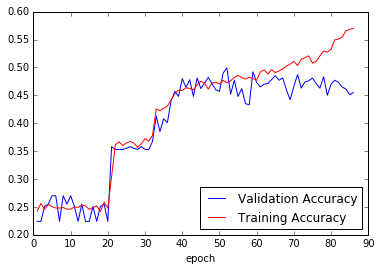

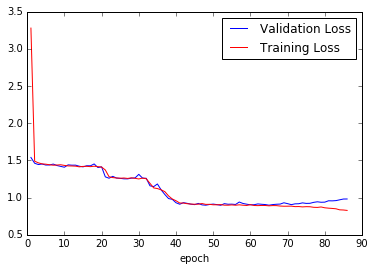

In [14]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

log = h5py.File('Training_logs_DMN_plus.h5','r+') # Loading logs about change of training and validation loss and accuracy over epochs

y1 = log['val_acc'][...]
y2 = log['acc'][...]

x = np.arange(1,len(y1)+1,1) # (1 = starting epoch, len(y1) = no. of epochs, 1 = step) 

plt.plot(x,y1,'b',label='Validation Accuracy') 
plt.plot(x,y2,'r',label='Training Accuracy')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.show()

y1 = log['val_loss'][...]
y2 = log['loss'][...]

plt.plot(x,y1,'b',label='Validation Loss')
plt.plot(x,y2,'r',label='Training Loss')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.show()

In [15]:
with tf.Session() as sess: # Begin session
    
    print 'Loading pre-trained weights for the model...'
    saver = tf.train.Saver()
    saver.restore(sess, 'DMN_Model_Backup/model.ckpt')
    sess.run(tf.global_variables())
    print '\nRESTORATION COMPLETE\n'
    
    print 'Testing Model Performance...'
    
    total_test_loss = 0
    total_test_acc = 0
    
    test_batch_size = 100 #(should be able to divide total no. of test samples without remainder)
    batches_test_fact_stories,batches_test_questions,batches_test_answers = create_batches(test_fact_stories,test_questions,test_answers,test_batch_size)
        
    for i in xrange(len(batches_test_questions)):
        test_loss, test_acc = sess.run([cost, accuracy], 
                                        feed_dict={tf_facts: batches_test_fact_stories[i], 
                                                   tf_questions: batches_test_questions[i], 
                                                   tf_answers: batches_test_answers[i],
                                                   keep_prob: 1})
        total_test_loss += test_loss
        total_test_acc += test_acc
                      
            
    avg_test_loss = total_test_loss/len(batches_test_questions) 
    avg_test_acc = total_test_acc/len(batches_test_questions) 


    print "\nTest Loss= " + \
          "{:.3f}".format(avg_test_loss) + ", Test Accuracy= " + \
          "{:.3f}%".format(avg_test_acc*100)+""


Loading pre-trained weights for the model...
INFO:tensorflow:Restoring parameters from DMN_Model_Backup/model.ckpt

RESTORATION COMPLETE

Testing Model Performance...

Test Loss= 0.891, Test Accuracy= 49.100%
